In [9]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [10]:
PATH = "/home/tukl/projects/Art-Classifier/art_classifier/data/wikipaintings_full"

train_dir = os.path.join(PATH, 'wikipaintings_train')
validation_dir = os.path.join(PATH, 'wikipaintings_val')
test_dir = os.path.join(PATH, 'wikipaintings_test')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 66542 files belonging to 25 classes.


In [11]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 7383 files belonging to 25 classes.


In [12]:
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                           shuffle=False,
                                                           batch_size=BATCH_SIZE,
                                                           image_size=IMG_SIZE)

Found 8191 files belonging to 25 classes.


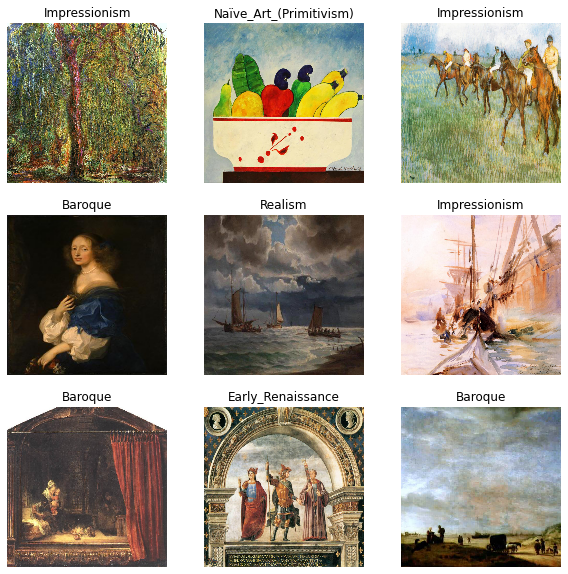

In [16]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [17]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [18]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

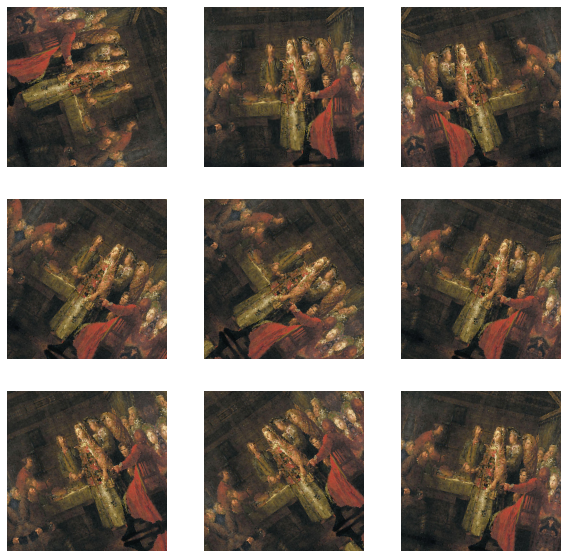

In [19]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [20]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [21]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [22]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


In [23]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

2022-02-10 16:32:04.167657: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201
2022-02-10 16:32:05.217817: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-02-10 16:32:05.218793: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2022-02-10 16:32:05.218804: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2022-02-10 16:32:05.218841: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be 

(32, 5, 5, 1280)


2022-02-10 16:32:05.743291: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [24]:
base_model.trainable = False

In [25]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [26]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [27]:
prediction_layer = tf.keras.layers.Dense(25)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 25)


In [28]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [30]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [31]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [32]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

231/231 [==============================] - 55s 226ms/step - loss: 3.7027 - accuracy: 0.0423


In [33]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 3.70
initial accuracy: 0.04


In [34]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
2080/2080 [==============================] - 545s 261ms/step - loss: 2.6488 - accuracy: 0.2278 - val_loss: 2.2372 - val_accuracy: 0.3056
Epoch 2/10
2080/2080 [==============================] - 207s 99ms/step - loss: 2.2197 - accuracy: 0.3198 - val_loss: 2.0761 - val_accuracy: 0.3497
Epoch 3/10
2080/2080 [==============================] - 207s 99ms/step - loss: 2.0931 - accuracy: 0.3508 - val_loss: 2.0110 - val_accuracy: 0.3696
Epoch 4/10
2080/2080 [==============================] - 206s 99ms/step - loss: 2.0205 - accuracy: 0.3668 - val_loss: 1.9667 - val_accuracy: 0.3816
Epoch 5/10
2080/2080 [==============================] - 207s 99ms/step - loss: 1.9788 - accuracy: 0.3779 - val_loss: 1.9471 - val_accuracy: 0.3875
Epoch 6/10
2080/2080 [==============================] - 207s 99ms/step - loss: 1.9450 - accuracy: 0.3867 - val_loss: 1.9250 - val_accuracy: 0.3941
Epoch 7/10
2080/2080 [==============================] - 206s 99ms/step - loss: 1.9177 - accuracy: 0.3939 - val_loss: 

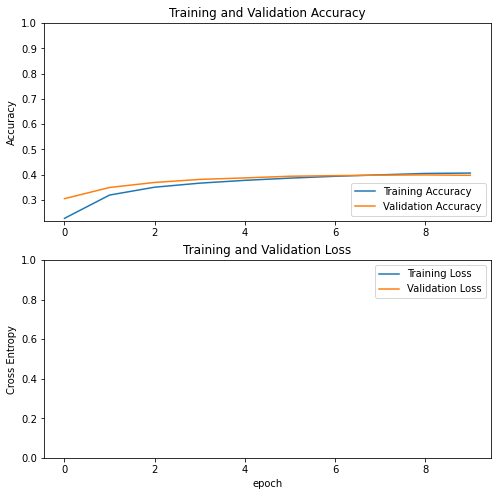

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [36]:
base_model.trainable = True

In [37]:
print("Number of layers in the base model: ", len(base_model.layers))

fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
      layer.trainable = False

Number of layers in the base model:  154


In [41]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [42]:
len(model.trainable_variables)

56

In [43]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
2080/2080 [==============================] - 210s 99ms/step - loss: 1.8050 - accuracy: 0.4253 - val_loss: 1.8218 - val_accuracy: 0.4124
Epoch 11/20
2080/2080 [==============================] - 207s 99ms/step - loss: 1.7050 - accuracy: 0.4524 - val_loss: 1.7443 - val_accuracy: 0.4409
Epoch 12/20
2080/2080 [==============================] - 206s 99ms/step - loss: 1.6406 - accuracy: 0.4689 - val_loss: 1.7068 - val_accuracy: 0.4513
Epoch 13/20
2080/2080 [==============================] - 207s 99ms/step - loss: 1.5941 - accuracy: 0.4847 - val_loss: 1.6510 - val_accuracy: 0.4649
Epoch 14/20
2080/2080 [==============================] - 206s 99ms/step - loss: 1.5486 - accuracy: 0.4992 - val_loss: 1.6466 - val_accuracy: 0.4624
Epoch 15/20
2080/2080 [==============================] - 206s 99ms/step - loss: 1.5096 - accuracy: 0.5086 - val_loss: 1.6217 - val_accuracy: 0.4684
Epoch 16/20
2080/2080 [==============================] - 207s 99ms/step - loss: 1.4768 - accuracy: 0.5199 - val_

In [44]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

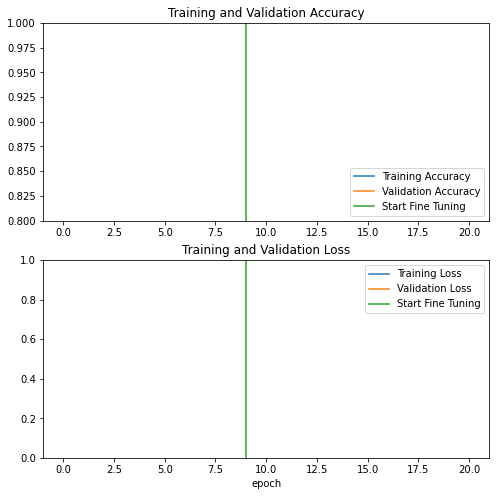

In [48]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [46]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

256/256 [==============================] - 30s 117ms/step - loss: 1.6231 - accuracy: 0.4736
Test accuracy : 0.47356855869293213


In [ ]:
# # Retrieve a batch of images from the test set
# image_batch, label_batch = test_dataset.as_numpy_iterator().next()
# predictions = model.predict_on_batch(image_batch).flatten()

# # Apply a sigmoid since our model returns logits
# predictions = tf.nn.sigmoid(predictions)
# predictions = tf.where(predictions < 0.5, 0, 1)

# print('Predictions:\n', predictions.numpy())
# print('Labels:\n', label_batch)

# plt.figure(figsize=(10, 10))
# for i in range(9):
#   ax = plt.subplot(3, 3, i + 1)
#   plt.imshow(image_batch[i].astype("uint8"))
#   plt.title(class_names[predictions[i]])
#   plt.axis("off")